In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preprocesseddata/prepared_data/test/images/48.png
/kaggle/input/preprocesseddata/prepared_data/test/images/61.png
/kaggle/input/preprocesseddata/prepared_data/test/images/37.png
/kaggle/input/preprocesseddata/prepared_data/test/images/35.png
/kaggle/input/preprocesseddata/prepared_data/test/images/11.png
/kaggle/input/preprocesseddata/prepared_data/test/images/31.png
/kaggle/input/preprocesseddata/prepared_data/test/images/4.png
/kaggle/input/preprocesseddata/prepared_data/test/images/43.png
/kaggle/input/preprocesseddata/prepared_data/test/images/40.png
/kaggle/input/preprocesseddata/prepared_data/test/images/33.png
/kaggle/input/preprocesseddata/prepared_data/test/images/9.png
/kaggle/input/preprocesseddata/prepared_data/test/images/56.png
/kaggle/input/preprocesseddata/prepared_data/test/images/55.png
/kaggle/input/preprocesseddata/prepared_data/test/images/50.png
/kaggle/input/preprocesseddata/prepared_data/test/images/49.png
/kaggle/input/preprocesseddata/prepared_da

In [2]:
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
train_images  = glob('../input/preprocesseddata/prepared_data/train/images/*.png')
train_masks = glob('../input/preprocesseddata/prepared_data/train/masks/*.png')

In [4]:
img = []
for filename in train_images:
    img.append(filename)
img.sort()

In [5]:
mask = []
for filename in train_masks:
    mask.append(filename)
mask.sort()

In [6]:
# Set some parameters
im_width = 512
im_height = 512
border = 5
ids = next(os.walk("../input/preprocesseddata/prepared_data/train/images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  268


In [7]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [8]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("../input/preprocesseddata/prepared_data/train/images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("../input/preprocesseddata/prepared_data/train/masks/"+id_, grayscale=True))
    mask = resize(mask, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/268 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [9]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Lung Nodule')

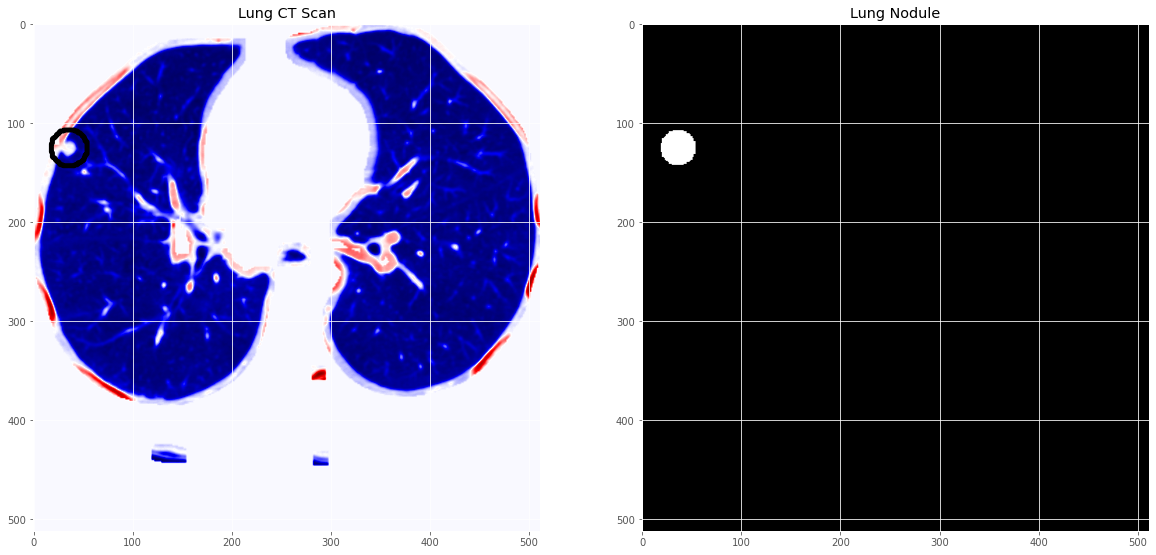

In [10]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: 
    # draw a boundary(contour) in the original image 
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Lung CT Scan')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Lung Nodule')

In [11]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [12]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2), padding='same')(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2),padding='same')(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2),padding='same')(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2),padding='same')(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [13]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

2022-05-07 16:24:53.781264: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [15]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('./lung_nodules_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [16]:
results = model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

2022-05-07 16:24:55.175948: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
8/8 [==============================] - 175s 21s/step - loss: 0.7473 - accuracy: 0.5841 - val_loss: 13.7697 - val_accuracy: 0.1505

Epoch 00001: val_loss improved from inf to 13.76968, saving model to ./lung_nodules_model.h5
Epoch 2/10
8/8 [==============================] - 168s 21s/step - loss: 0.5487 - accuracy: 0.9413 - val_loss: 54.9287 - val_accuracy: 0.0020

Epoch 00002: val_loss did not improve from 13.76968
Epoch 3/10
8/8 [==============================] - 167s 21s/step - loss: 0.4664 - accuracy: 0.9753 - val_loss: 16.9327 - val_accuracy: 0.0074

Epoch 00003: val_loss did not improve from 13.76968
Epoch 4/10
8/8 [==============================] - 168s 21s/step - loss: 0.4234 - accuracy: 0.9859 - val_loss: 8.1438 - val_accuracy: 0.0309

Epoch 00004: val_loss improved from 13.76968 to 8.14383, saving model to ./lung_nodules_model.h5
Epoch 5/10
8/8 [==============================] - 166s 21s/step - loss: 0.3941 - accuracy: 0.9899 - val_loss: 0.7280 - val_accuracy: 0.7962

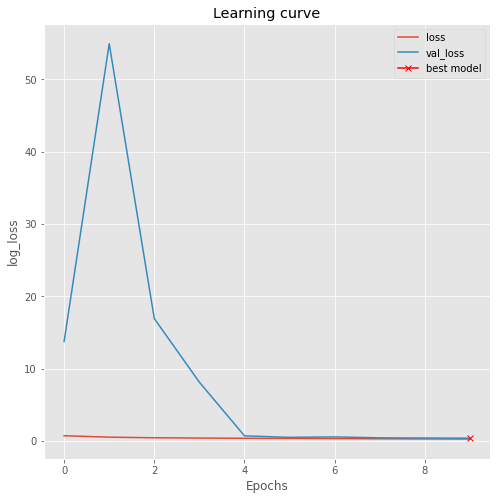

In [17]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [18]:
# load the best model
model.load_weights('./lung_nodules_model.h5')

In [19]:
model.save('./unet_model.h5')

In [20]:
from keras.models import model_from_json
model_json = model.to_json()

with open("./unet_model_weights.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("./unet_model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 4s 4s/step - loss: 0.4100 - accuracy: 0.9958


[0.409972220659256, 0.9957706332206726]

In [22]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1/1 [==============================] - 4s 4s/step


In [23]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [24]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Lung CT Scan ')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground Truth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted Nodule')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted Nodule Binary')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


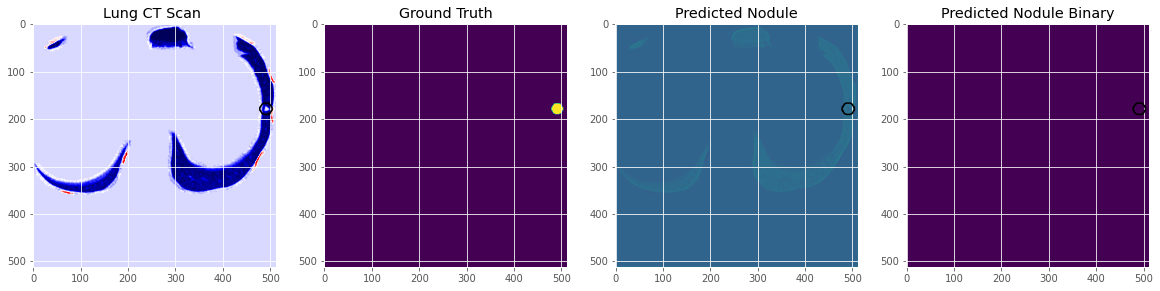

In [25]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


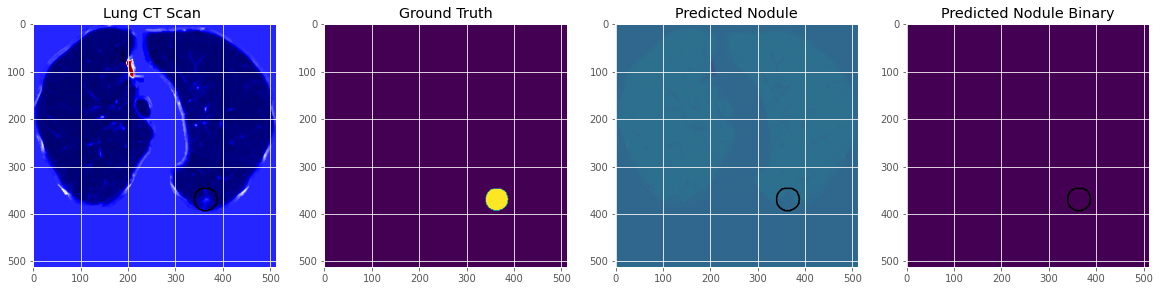

In [26]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


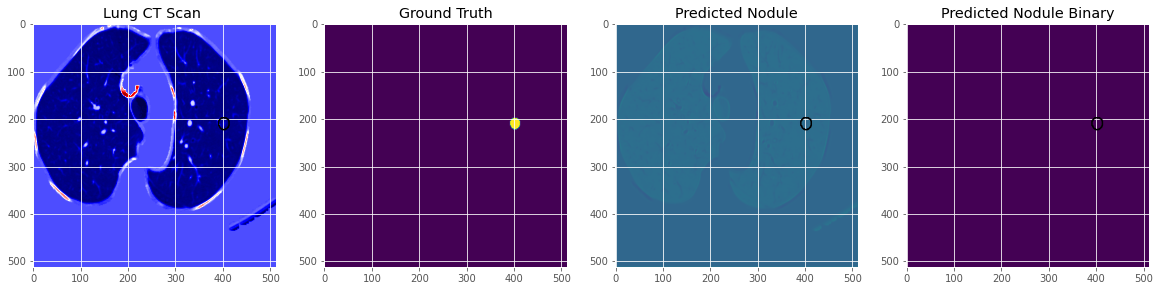

In [27]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


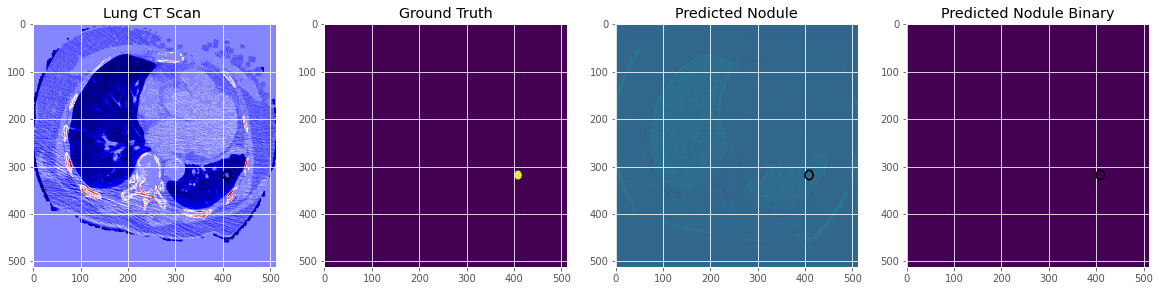

In [28]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [29]:
# LOAD MODEL
from keras.models import load_model
model = load_model('./unet_model.h5')

In [30]:
test_images  = glob('../input/preprocesseddata/prepared_data/test/images/*.png')
test_masks = glob('../input/preprocesseddata/prepared_data/test/masks/*.png')

In [31]:
img = []
for filename in test_images:
    img.append(filename)
img.sort()
mask = []
for filename in test_masks:
    mask.append(filename)
mask.sort()

In [32]:
# Set some parameters
im_width = 512
im_height = 512
border = 5
ids = next(os.walk("../input/preprocesseddata/prepared_data/test/images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  67


In [33]:
X = np.zeros((1, im_height, im_width, 1), dtype=np.float32)
y = np.zeros((1, im_height, im_width, 1), dtype=np.float32)

In [34]:
# tqdm is used to display the progress bar
from tqdm import tqdm
images_path = "../input/preprocesseddata/prepared_data/test/images/" 
masks_path = "../input/preprocesseddata/prepared_data/test/masks/"
img = load_img(images_path+'1.png', grayscale=True)
x_img = img_to_array(img)
x_img = resize(x_img, (512, 512, 1), mode = 'constant', preserve_range = True)
# Load masks
mask = img_to_array(load_img(masks_path+'1.png', grayscale=True))
mask = resize(mask, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Save images
X[0] = x_img/255.0
y[0] = mask/255.0

In [35]:
preds_val = model.predict(X, verbose=1)

1/1 [==============================] - 1s 507ms/step


In [36]:
preds_val_t = (preds_val > 0.5).astype(np.uint8)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


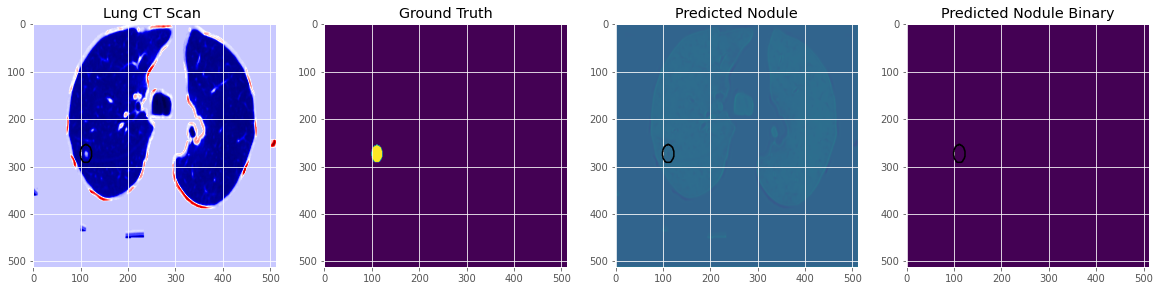

In [37]:
# Check if valid data looks all right
plot_sample(X, y, preds_val, preds_val_t)